# Avoid Negative Predictions in Forecasting

When training a forecasting model, even if none of the training observations are negative, some predictions may turn out to be negative. This is quite common when trying to predict attendance, sales, or rainfall, among other things. To avoid this, it is possible to use the following approaches:

+ Use a <i>log+K</i> transformation to always have positive values in the transformed time series. <i>K</i> is a positive integer to avoid the undefinability of the $log(x)$ function at 0. Despite the simplicity of the approach, one must be aware that [some caveats may arise](https://florianwilhelm.info/2020/05/honey_i_shrunk_the_target_variable/) depending on the metric we use to optimize our models.

+ Use a different link function in the models. The link function provides the relationship between the linear predictor and the expected value of the response variable. When using machine learning models, several algorithms support different objective functions to account for this situation. For example, when predicting the number of visitors, one can use `count:poisson` in XGBoost or LightGBM as well as gamma regression if the target is always strictly positive.

The following tutorial will explore both possibilities.

## Libraries

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
from sklearn.linear_model import Ridge
from sklearn.linear_model import GammaRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import backtesting_forecaster

## Data

In [2]:
# Downloading data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-'
       'learning-python/master/data/bike_sharing_dataset_clean.csv')
data = pd.read_csv(url, usecols=['date_time', 'users'], nrows=1000)
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date_time')
data = data.asfreq('h')
data = data.sort_index()

In [3]:
# Split train-test
# ==============================================================================
end_train = '2011-01-31 23:59:00'
data_train = data.loc[: end_train, :]
data_test  = data.loc[end_train:, :]

print(f"Dates train: {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates test : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train: 2011-01-01 00:00:00 --- 2011-01-31 23:00:00  (n=744)
Dates test : 2011-02-01 00:00:00 --- 2011-02-11 15:00:00  (n=256)


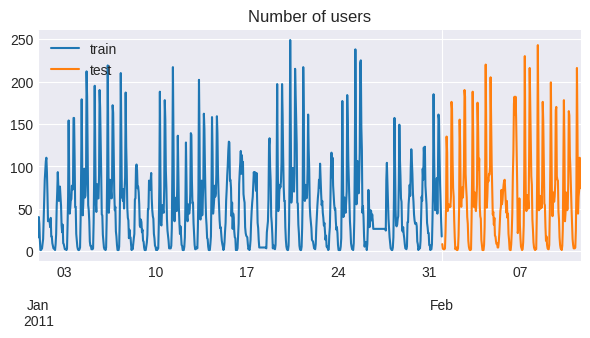

In [4]:
# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['users'].plot(ax=ax, label='train')
data_test['users'].plot(ax=ax, label='test')
ax.set_title('Number of users')
ax.set_xlabel('')
ax.legend();

## Forecaster

In [5]:
# Create a forecaster and train it
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = Ridge(random_state=123),
                 lags      = 24
             )

In [6]:
# Backtesting predictions on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['users'],
                          steps                 = 24,
                          metric                = 'mean_squared_error',
                          initial_train_size    = len(data_train),
                          fixed_train_size      = False,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/11 [00:00<?, ?it/s]

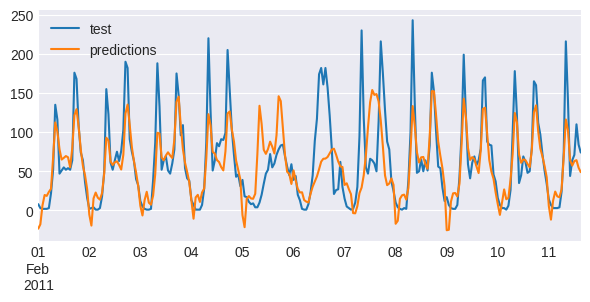

In [7]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_test['users'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.set_xlabel('')
ax.legend();

The graph above shows that some predictions are negative.

In [8]:
# Negative predictions
# ==============================================================================
predictions[predictions.pred < 0]

,pred
2011-02-01 00:00:00,-23.337236
2011-02-01 01:00:00,-17.691405
2011-02-02 00:00:00,-5.243456
2011-02-02 01:00:00,-19.363139
2011-02-03 01:00:00,-6.441943
2011-02-04 01:00:00,-10.579940
2011-02-05 00:00:00,-6.026119
2011-02-05 01:00:00,-21.396841
2011-02-07 04:00:00,-3.412043
2011-02-07 05:00:00,-3.701964


## Modeling time series in logarithmic scale

In [9]:
# Transform data into a logarithmic scale
# =============================================================================
data_log = np.log1p(data)
data_train_log = np.log1p(data_train)
data_test_log  = np.log1p(data_test)

In [10]:
# Create a forecaster and train it
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = Ridge(random_state=123),
                 lags      = 24,
             )

# Backtesting predictions on test data
# ==============================================================================
# Since the data has been transformed outside the forecaster, the predictions
# and metric are not in the original scale. They need to be transformed back.
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data_log['users'],
                          steps                 = 24,
                          metric                = 'mean_squared_error',
                          initial_train_size    = len(data_train_log),
                          fixed_train_size      = False,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/11 [00:00<?, ?it/s]

In [11]:
# Revert the transformation
# ==============================================================================
predictions = np.expm1(predictions)
predictions.head(4)

,pred
2011-02-01 00:00:00,7.936823
2011-02-01 01:00:00,4.210682
2011-02-01 02:00:00,3.009993
2011-02-01 03:00:00,3.083922


In [12]:
# Backtesting metric (test data)
# ==============================================================================
# The error metric is calculated once the transformation is reversed.
metric = mean_squared_error(y_true=data_test['users'], y_pred=predictions)
print(f"Backtesting metric (test data): {metric}")

Backtesting metric (test data): 1991.9332571759883


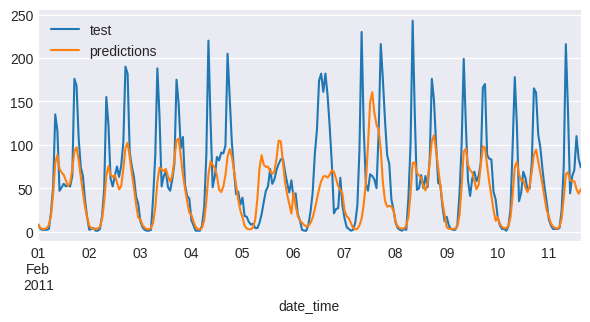

In [13]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_test['users'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

## Include a logarithmic transformer as part of the forecaster

Using scikit-learn [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html) it is possible to include custom transformers in the forecaster object, for example, a logarithmic transformation. If the `FunctionTransformer` has an inverse function, the output of the predict method is automatically transformed back to the original scale.

In [14]:
# Create a custom transformer
# =============================================================================
transformer_y = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

# Create a forecaster and train it
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor        = Ridge(random_state=123),
                 lags             = 24,
                 transformer_y    = transformer_y,
                 transformer_exog = None
             )
forecaster.fit(data['users'])

# Backtesting predictions on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['users'],
                          steps                 = 24,
                          metric                = 'mean_squared_error',
                          initial_train_size    = len(data_train),
                          fixed_train_size      = False,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          verbose               = False,
                          show_progress         = True
                      )

# Since the transformation is included in the forecaster, predictions are
# automatically transformed back into the original scale. And the metric is
# calculated in the original scale.
metric

  0%|          | 0/11 [00:00<?, ?it/s]

,mean_squared_error
0,1991.933257


In [15]:
# Backtest predictions
# ==============================================================================
predictions.head()

,pred
2011-02-01 00:00:00,7.936823
2011-02-01 01:00:00,4.210682
2011-02-01 02:00:00,3.009993
2011-02-01 03:00:00,3.083922
2011-02-01 04:00:00,3.865169


The same results are obtained as if the data were log-transformed outside the model. However, by including the log transformation in the model, all inverse transformations are handled automatically.

## Usage of link functions

A forecaster with a linear model (scikit learn GammaRegressor) that uses a different link function is evaluated.

In [16]:
# Create a forecaster and train it
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = GammaRegressor(alpha=1, max_iter=100000),
                 lags      = 20,
             )

# Backtesting predictions on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['users'],
                          steps                 = 24,
                          metric                = 'mean_squared_error',
                          initial_train_size    = len(data_train),
                          fixed_train_size      = False,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          verbose               = False,
                          show_progress         = True
                      )

metric

  0%|          | 0/11 [00:00<?, ?it/s]

,mean_squared_error
0,3509.672762


In [17]:
# Backtest predictions
# ==============================================================================
predictions.head()

,pred
2011-02-01 00:00:00,6.685814
2011-02-01 01:00:00,10.238382
2011-02-01 02:00:00,11.950783
2011-02-01 03:00:00,9.194086
2011-02-01 04:00:00,6.372470


In this case the gamma regressor model performed poorly, but if we look to the negative results:

In [18]:
# Negative predictions
# ======================================================================================
predictions[predictions.pred < 0]

,pred


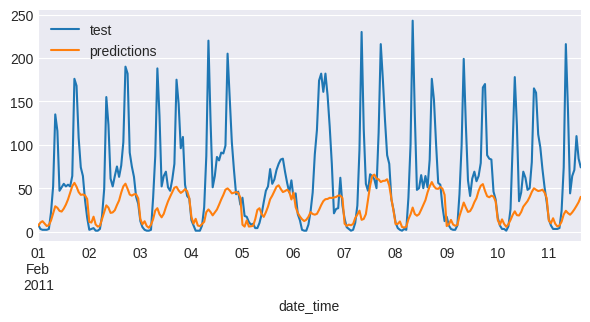

In [19]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_test['users'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

## Usage of XGBoost objective functions

Now a XGBoost model is trained, but with the objective function set to `reg:gamma`, so that the output is a mean of the gamma distribution, which is defined for positive values only.

In [20]:
# Create forecaster and train
# ==============================================================================
params = {
    'tree_method': 'hist',
    'objective': 'reg:gamma'
}

forecaster = ForecasterRecursive(
                 regressor = XGBRegressor(**params),
                 lags      = 24,
             )

# Backtesting predictions on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['users'],
                          steps                 = 24,
                          metric                = 'mean_squared_error',
                          initial_train_size    = len(data_train),
                          fixed_train_size      = False,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          verbose               = False,
                          show_progress         = True
                      )

metric

  0%|          | 0/11 [00:00<?, ?it/s]

,mean_squared_error
0,1915.458228


In [21]:
# Negative predictions
predictions[predictions.pred < 0]

,pred


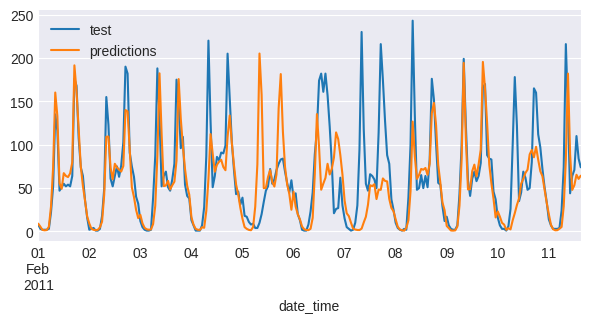

In [22]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_test['users'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

The forecaster's performance is better than using a Ridge regressor with a log-transformer, and no negative predictions are made.